In [4]:
import os, glob
import random
import cv2
import numpy as np
import pandas as pd
!pip install opencv-contrib-python
import PIL
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, applications
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import Sequence 
import matplotlib.pyplot as plt
from IPython.display import Image
import json
import os
import gc
from numpy.random import seed
seed(8)

%matplotlib inline

In [5]:
!pip install git+https://github.com/qubvel/efficientnet -q
import efficientnet.tfkeras as efn 

# A look at the data

In [6]:
DATA_DIR = '../input/iwildcam-2020-fgvc7/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'

# load the megadetector results
megadetector_results = json.load(open(DATA_DIR + 'iwildcam2020_megadetector_results.json'))

# load train images annotations
train_info = json.load(open(DATA_DIR + 'iwildcam2020_train_annotations.json'))
# split json into several pandas dataframes
train_annotations = pd.DataFrame(train_info['annotations'])
train_images = pd.DataFrame(train_info['images'])
train_categories = pd.DataFrame(train_info['categories'])

In [7]:
train_annotations.head()

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2


In [8]:
train_images.head()

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,267,2013-08-08 11:45:00.000,96b00332-21bc-11ea-a13a-137349068a90,1,96b004ea-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,1,264,2013-08-01 22:31:00.000,879d74d8-21bc-11ea-a13a-137349068a90,1,879d7654-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,1,45,2013-04-17 11:15:00.000,9017f7aa-21bc-11ea-a13a-137349068a90,1,9017f8cc-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,1,45,2013-04-23 08:26:00.000,90d93c58-21bc-11ea-a13a-137349068a90,1,90d93e38-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,1,45,2013-04-24 13:51:00.000,887cd0ec-21bc-11ea-a13a-137349068a90,1,887cd29a-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


In [9]:
train_categories.head()

,count,id,name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor


In [10]:
print('Number of categories: ' + str(len(train_categories)))

Number of categories: 267


In [11]:
print('Count of images in the training set: ' + str(train_annotations.image_id.nunique()))

Count of images in the training set: 217959


In [12]:
# Animals per image
counts_per_image = train_annotations.groupby(by=['image_id']).sum().reset_index()[['image_id', 'count']].sort_values(by=['count'], ascending=False)
counts_per_image.head(5)

,image_id,count
130497,91d0f146-21bc-11ea-a13a-137349068a90,80
190827,97062316-21bc-11ea-a13a-137349068a90,75
42664,8a28c004-21bc-11ea-a13a-137349068a90,75
39846,89eab214-21bc-11ea-a13a-137349068a90,75
216092,9926a95e-21bc-11ea-a13a-137349068a90,70


In [13]:
counts_per_image.tail(5)

,image_id,count
75105,8d028ab2-21bc-11ea-a13a-137349068a90,-1
75101,8d0274fa-21bc-11ea-a13a-137349068a90,-1
156729,9415a4e2-21bc-11ea-a13a-137349068a90,-1
175047,959f6226-21bc-11ea-a13a-137349068a90,-1
161439,947c57c8-21bc-11ea-a13a-137349068a90,-1


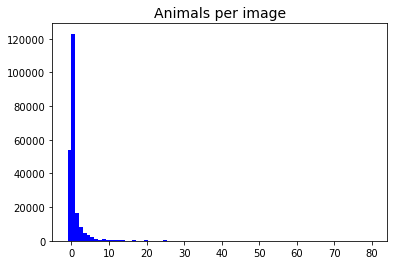

In [14]:
plt.hist(counts_per_image['count'].values, bins=80, color='blue')
plt.title('Animals per image', fontsize=14)
plt.show()

In [15]:
category_counts_per_image = train_annotations.groupby(by=['image_id', 'category_id']).sum().reset_index()[['image_id', 'category_id', 'count']]\
.sort_values(by=['count'], ascending=False)
# merge with category names
category_counts_per_image = category_counts_per_image.merge(train_categories[['id', 'name']].rename(columns={'id':'category_id'}), on=['category_id'])
# output top-5
category_counts_per_image.head(5)

,image_id,category_id,count,name
0,91d0f146-21bc-11ea-a13a-137349068a90,71,80,bos taurus
1,97062316-21bc-11ea-a13a-137349068a90,71,75,bos taurus
2,8a28c004-21bc-11ea-a13a-137349068a90,71,75,bos taurus
3,89eab214-21bc-11ea-a13a-137349068a90,71,75,bos taurus
4,9926a95e-21bc-11ea-a13a-137349068a90,71,70,bos taurus


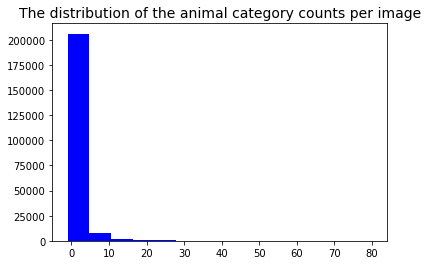

In [16]:
plt.hist(category_counts_per_image['count'].values, bins=14, color='blue')
plt.title('The distribution of the animal category counts per image', fontsize=14)
plt.show()

In [17]:
#Now let's look at the number of images for each category:
num_categories = train_categories.sort_values(by=['count'], ascending=False)
# list the top-5
num_categories.head(5)

,count,id,name
0,78981,0,empty
36,33313,75,human
188,16713,372,meleagris ocellata
189,12908,374,crax rubra
146,9052,317,cephalophus nigrifrons


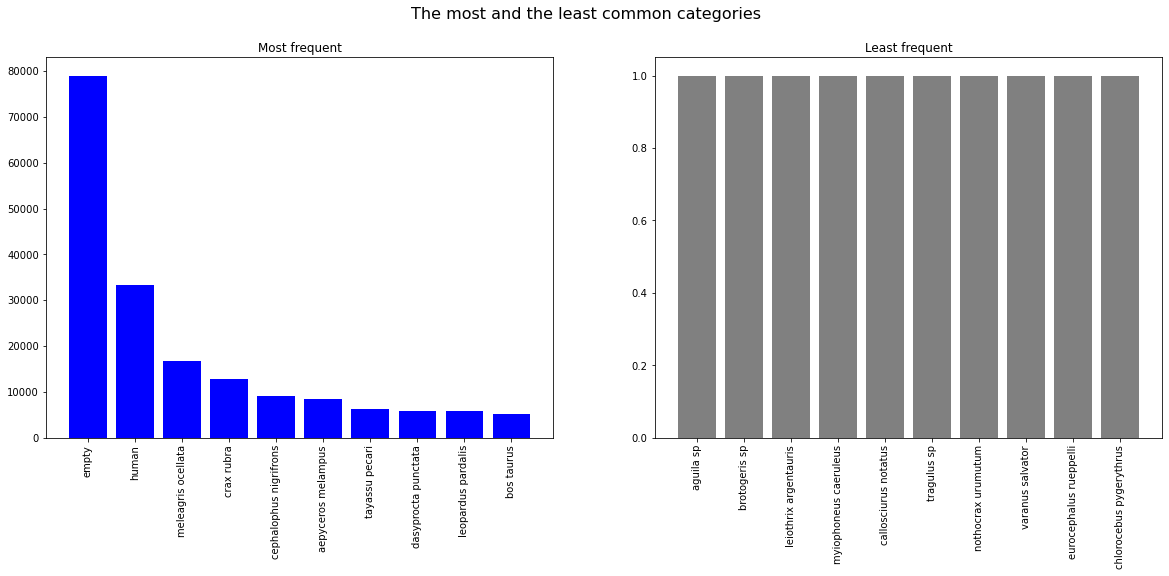

In [18]:
fig, axes = plt.subplots(1,2, figsize=(20,7))
width = 0.8
n_categories = 10
# First n
axes[0].bar(x=range(n_categories), height=num_categories['count'].values[:n_categories], width=width, color='blue')
axes[0].set_xticks(np.array(range(n_categories)))
axes[0].set_xticklabels(num_categories['name'].values[:n_categories], rotation=90)
axes[0].set_title('Most frequent')
# Last n
axes[1].bar(x=range(n_categories), height=num_categories[num_categories['count'] > 0]['count'].values[-n_categories:], width=width, color='gray')
axes[1].set_xticks(np.array(range(n_categories)))
axes[1].set_xticklabels(num_categories[num_categories['count'] > 0]['name'].values[-n_categories:], rotation=90)
axes[1].set_title('Least frequent')

plt.suptitle('The most and the least common categories', fontsize=16)
plt.show()

In [19]:
print('The number of unique locations is {}'.format(train_images.location.nunique()))
print('The average number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().mean()))
print('The minimum number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().min()))
print('The maximum number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().max()))

The number of unique locations is 325
The average number of images per location is 670.6430769230769
The minimum number of images per location is 1
The maximum number of images per location is 8844


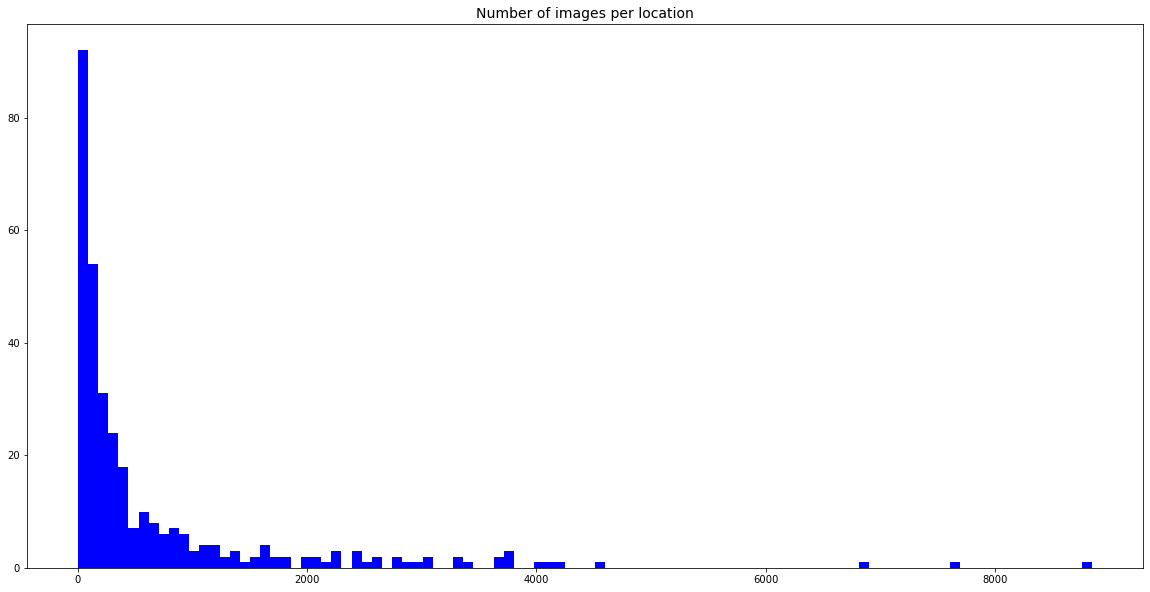

In [20]:
plt.figure(figsize=(20,10))
plt.hist(train_images.groupby(by=['location']).id.count(), bins=100, color='blue')
plt.title('Number of images per location', fontsize=14)
plt.show()

In [21]:
frames_per_sequence = train_images.groupby(by=['seq_id']).frame_num.max()

print('The average number of frames is {}'.format(frames_per_sequence.mean()))
print('The minimum number of frames is {}'.format(frames_per_sequence.min()))
print('The maximum number of frames is {}'.format(frames_per_sequence.max()))

The average number of frames is 6.170176231360145
The minimum number of frames is -1
The maximum number of frames is 3899


In [22]:
def get_first_category(img_id):
    """Find first the image category by id."""
    # get category id
    category_id = train_annotations[train_annotations.image_id == img_id].category_id.values[0]
    # get category name
    category_name = train_categories[train_categories.id == category_id].name.values[0]
    return category_id, category_name

def visualize_image_grid(rows, cols):
    """Visualize random grid of images with the first category."""
    filenames = train_images.file_name.unique()
    
    np.random.seed(31)
    img_idx = np.random.randint(len(filenames), size=rows * cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15,7))
    
    for r in range(rows):
        for c in range(cols):
            # get the image and image id
            filename = filenames[img_idx[rows*r + c]]
            img_id = filename.split('.')[0]
            # get the category
            category_id, category = get_first_category(img_id)
            
            img = PIL.Image.open(TRAIN_DIR + filename)
            
            axs[r,c].imshow(img)
            axs[r,c].axis('off')
            axs[r,c].set_title('{}:{}'.format(category_id, category))
            
    plt.suptitle('Train images', fontsize=16)
    plt.show()

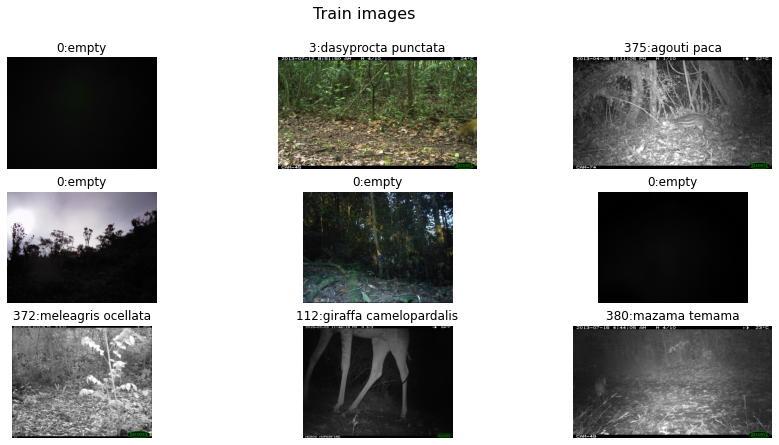

In [23]:
visualize_image_grid(3, 3)

In [24]:
def visualize_category(category_id, rows=3, cols=3, seed=42):
    """Function to visualize images of a specific category."""
    # filter by the category_id
    copy = train_annotations[train_annotations.category_id == category_id]
    # get the category name
    category_name = train_categories[train_categories.id == category_id].name.values[0]
    
    # get random indices
    np.random.seed(seed)
    img_idx = np.random.randint(len(copy), size=rows * cols)
    
    # plot images
    fig, axs = plt.subplots(rows, cols, figsize=(15,7))
    
    for r in range(rows):
        for c in range(cols):
            # get the image and image id
            filename = copy.iloc[img_idx[rows*r + c]].image_id + '.jpg'
            img_id = filename.split('.')[0]
            
            img = PIL.Image.open(TRAIN_DIR + filename)
            
            axs[r,c].imshow(img)
            axs[r,c].axis('off')
            axs[r,c].set_title('{}:{}'.format(category_id, category_name))
            
    plt.suptitle('Train images for {}:{}'.format(category_id, category_name), fontsize=16)
    plt.show()

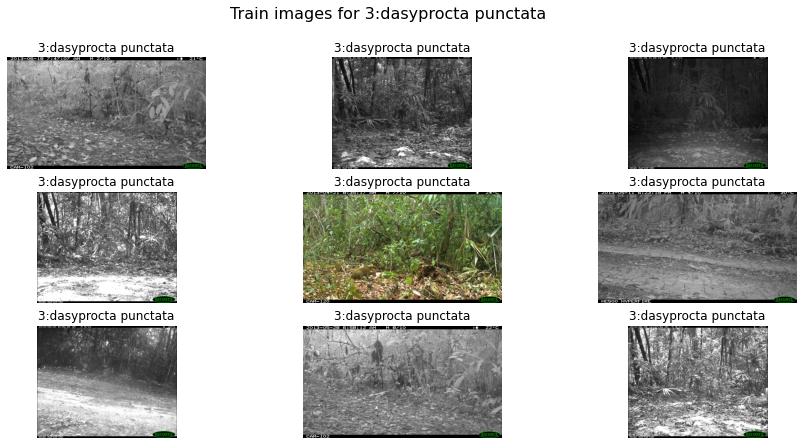

In [25]:
visualize_category(3)

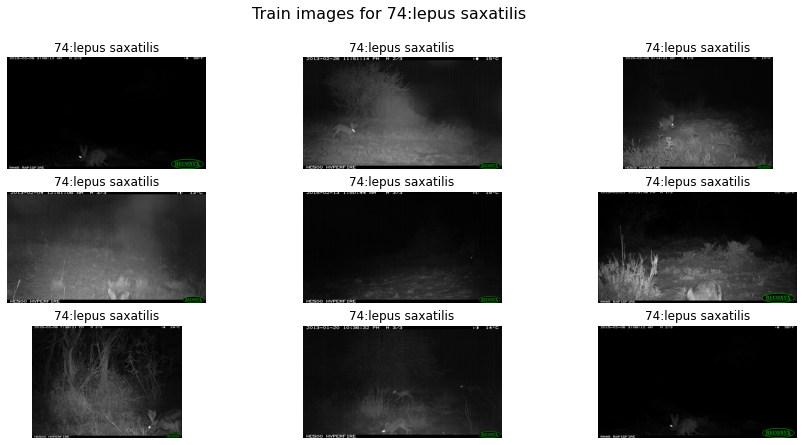

In [26]:
visualize_category(74)

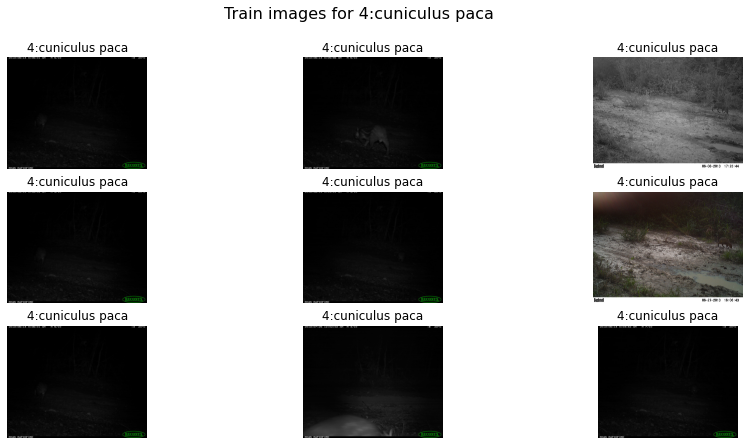

In [27]:
visualize_category(4) 

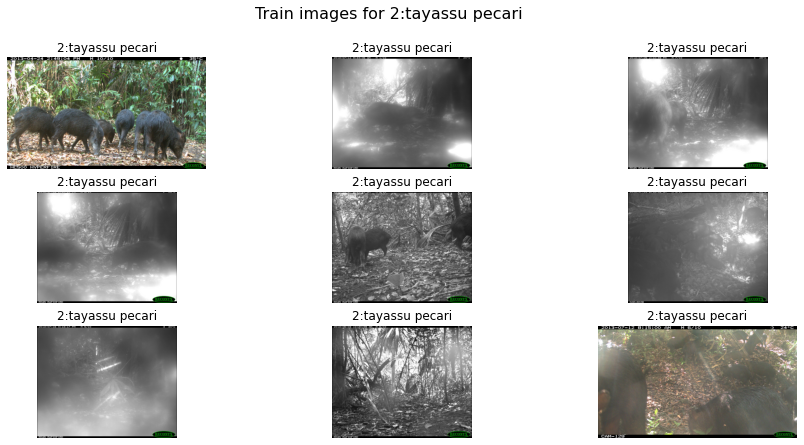

In [28]:
visualize_category(2) 

In [29]:
def visualize_top_categories(n_categories=4, n_cols=4, seed=35):
    """Function to plot a grid of n_cols images for each of the top n_categories from the train set."""
    np.random.seed(seed)
    
    # get ids for the top n_categories
    # excluding empty and human
    top_categories = num_categories['id'].values[2:n_categories+2]
    
    # setup the image grid
    fig, axs = plt.subplots(n_categories, n_cols, figsize=(18,10))
    
    for row in range(0, n_categories):
        # get the category 
        category_id = top_categories[row]
        
        # get the category name
        category_name = train_categories[train_categories.id == category_id].name.values[0]
        
        # filter the images by category
        copy = train_annotations[train_annotations.category_id == category_id]
        
        # get random indices
        img_idx = np.random.randint(len(copy), size=n_cols)
        
        for col in range(0, n_cols):
            # get the image and image id
            filename = copy.iloc[img_idx[col]].image_id + '.jpg'
            img_id = filename.split('.')[0]
            
            img = PIL.Image.open(TRAIN_DIR + filename)
            
            axs[row,col].imshow(img)
            axs[row,col].axis('off')
            axs[row,col].set_title('{}'.format(category_name))
            
    plt.suptitle('Training set pictures of top categories'.format(n_categories), fontsize=16)
    plt.show()

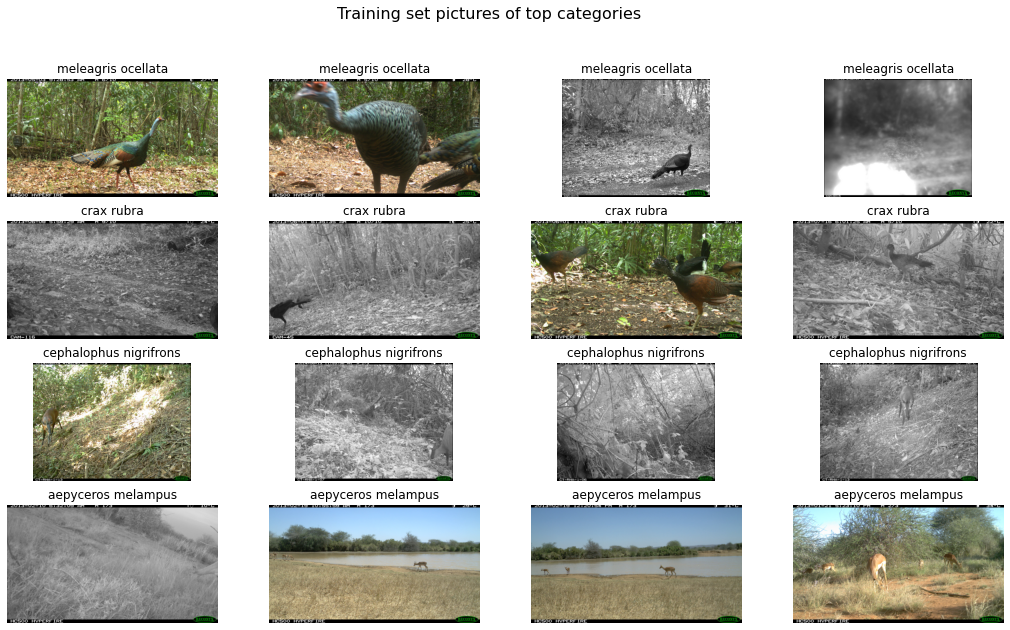

In [30]:
visualize_top_categories(n_categories=4)

# TPU and environment setup

In [31]:
os.listdir('../input')

['iwildcam2020-64-tf-records',
 'iwildcam2020-classes-dict',
 'iwildcam-2020-fgvc7']

In [32]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

print('tpu:', tpu)

TF_RECORDS_PATH = KaggleDatasets().get_gcs_path('iwildcam2020-64-tf-records')
# For optimal performance batch size should be a multiple of 16
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Constants
NUM_EPOCHS = 50
IMG_SIZE = 64
STEPS_PER_EPOCH = 147445 // BATCH_SIZE
NUM_DENSE_UNITS = 267

tpu: <tensorflow.python.distribute.cluster_resolver.tpu_cluster_resolver.TPUClusterResolver object at 0x7f41d0ceec10>


In [33]:
TRAINING_FILENAMES = tf.io.gfile.glob(TF_RECORDS_PATH + '/*train.rec')
TRAINING_FILENAMES.extend(tf.io.gfile.glob(TF_RECORDS_PATH + '/*zero.rec'))
TRAINING_FILENAMES

['gs://kds-64f5141c6a558be5ba7142bd559eff4cf57b13b7aeec703ccc7aaadb/myExternal0221_128_train.rec',
 'gs://kds-64f5141c6a558be5ba7142bd559eff4cf57b13b7aeec703ccc7aaadb/myExternal0221_128_zero.rec']

# Helper functions

In [34]:
def process_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [IMG_SIZE,IMG_SIZE, 3])
    return image

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)  
    if label is None:
        return image
    else:
        return image, label    
    
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = process_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = process_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_train_and_valid_dataset():
    # Load the dataset
    full_dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    # Extract the training part of the dataset
    train_dataset = full_dataset.shard(2, 0)
    # Extract the validation part of the dataset
    validation_dataset = full_dataset.shard(2, 1)
    train_dataset = train_dataset.map(data_augment, num_parallel_calls=AUTO)
    train_dataset = train_dataset.repeat() # the training dataset must repeat for several epochs
    train_dataset = train_dataset.shuffle(2048)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.cache()
    validation_dataset = validation_dataset.prefetch(AUTO)
    return train_dataset, validation_dataset

In [35]:
train_dataset, validation_dataset = get_train_and_valid_dataset()

In [36]:
sub_df = pd.read_csv('../input/iwildcam-2020-fgvc7/sample_submission.csv')
sub_df.head()

,Id,Category
0,873ff218-21bc-11ea-a13a-137349068a90,669
1,884103be-21bc-11ea-a13a-137349068a90,191
2,973feb64-21bc-11ea-a13a-137349068a90,245
3,8ebf4e44-21bc-11ea-a13a-137349068a90,335
4,95a33464-21bc-11ea-a13a-137349068a90,328


### Model

In [37]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB3(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(NUM_DENSE_UNITS, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
         loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    model.summary()

44113920/44107200 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 2, 2, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 267)               410379    
Total params: 11,193,907
Trainable params: 11,106,611
Non-trainable params: 87,296
_________________________________________________________________


In [38]:
# Early stopping callback. I did use it for some time, but in the end I opted to not use it to see the result of full 50 epochs
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
best_checkpoint='model.h5'
checkpoint = ModelCheckpoint(
    best_checkpoint, 
    monitor='val_accuracy', 
    verbose=1, 
    save_weights_only=True,
    mode='auto'
)

# Train

In [ ]:
%%time
history = model.fit(train_dataset, epochs = NUM_EPOCHS, verbose=2, callbacks=[checkpoint], steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_dataset
)

Epoch 1/50

Epoch 00001: saving model to model.h5
1151/1151 - 104s - loss: 1.9726 - sparse_categorical_accuracy: 0.4860 - val_loss: 3.5945 - val_sparse_categorical_accuracy: 0.3114
Epoch 2/50

Epoch 00002: saving model to model.h5
1151/1151 - 93s - loss: 1.4004 - sparse_categorical_accuracy: 0.6110 - val_loss: 5.7409 - val_sparse_categorical_accuracy: 0.2537
Epoch 3/50

Epoch 00003: saving model to model.h5
1151/1151 - 94s - loss: 1.0691 - sparse_categorical_accuracy: 0.6962 - val_loss: 2.7332 - val_sparse_categorical_accuracy: 0.4416
Epoch 4/50


In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Predictions on test data were not performed at the end. Initially I did perform them and they worked. However, something broke in the Kaggle environment a few days before submission deadline (it was working on Tuesday, but broken by Saturday) so that predicting was throwing weird errors from deep within Keras code. So I decided to report my results based on evaluating on the validation set only.